In [2]:
import os,sys
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt
from my_lgbm import *

# Code 경로 추가
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(""))))
print(sys.path[-1])

C:\Users\Minari\Documents\GitHub\level1-classificationinmachinelearning-recsys-06


In [3]:
df = pd.read_csv('after_eda2.csv').drop(columns=['difference', 'percent', 'supply_total', 'supply_new'])
df

,ID,_type,target,hashrate,taker_buy_sell_ratio,open_interest,funding_rates,coinbase_premium_index,utxo_count,transactions_count_total,total_liquidations,liquidation_diff,total_taker_volume,estimated_block_reward_usd,leverage_usage
0,2023-01-01 00:00:00,train,2.0,5.062917e+11,0.904774,6.271344e+09,0.005049,-0.059650,83308092.0,11457.0,0.012000,0.012000,9.785846e+07,104057.980295,325.805838
1,2023-01-01 01:00:00,train,1.0,1.687639e+11,1.655721,6.288683e+09,0.005049,-0.053047,83314883.0,5832.0,0.712000,-0.712000,6.376728e+07,104403.922724,326.706233
2,2023-01-01 02:00:00,train,1.0,3.375278e+11,1.027512,6.286796e+09,0.005049,-0.057952,83314090.0,5550.0,0.000000,0.000000,4.746397e+07,104021.263731,326.607363
3,2023-01-01 03:00:00,train,1.0,2.109549e+11,0.874477,6.284575e+09,0.005067,-0.058912,83326258.0,5245.0,0.593000,0.593000,6.130988e+07,103993.945406,326.491402
4,2023-01-01 04:00:00,train,2.0,2.953368e+11,0.966796,6.291582e+09,0.006210,-0.061373,83339168.0,6942.0,0.361000,0.361000,6.281486e+07,104100.262482,326.854700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,2024-04-26 03:00:00,test,NaN,3.153372e+11,NaN,1.486836e+10,NaN,-0.002376,179820708.0,10048.0,0.953500,0.466500,NaN,251543.725340,NaN
11548,2024-04-26 04:00:00,test,NaN,6.306744e+11,NaN,NaN,NaN,-0.018268,179833897.0,NaN,6.723208,6.431208,NaN,244385.395493,NaN
11549,2024-04-26 05:00:00,test,NaN,6.306744e+11,NaN,NaN,NaN,0.002866,179851249.0,NaN,7.013653,-3.419327,NaN,241170.877304,NaN
11550,2024-04-26 06:00:00,test,NaN,4.204496e+11,NaN,NaN,NaN,-0.003184,179852452.0,NaN,2.459000,-0.853000,NaN,232681.919923,NaN


In [4]:
df.isna().sum()

ID                               0
_type                            0
target                        2792
hashrate                         0
taker_buy_sell_ratio            31
open_interest                    4
funding_rates                   32
coinbase_premium_index           6
utxo_count                       1
transactions_count_total         4
total_liquidations               0
liquidation_diff                 0
total_taker_volume              31
estimated_block_reward_usd      24
leverage_usage                  28
dtype: int64

In [5]:
df['ID'] = pd.to_datetime(df['ID'])

In [6]:
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

In [7]:

# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1), 
    train_df["target"].astype(int), 
    test_size=0.2,
    random_state=42,
)

# lgb dataset
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)

# lgb params
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 0,
}

# lgb train
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=valid_data,
)

# lgb predict
y_valid_pred = lgb_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

acc: 0.4195205479452055, auroc: 0.6336320258636032


C:\Users\Minari\anaconda3\envs\bProject01\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [8]:
train_merged_df_with_target = x_train.copy()
train_merged_df_with_target['close'] = y_train

# 피어슨 상관계수 계산
correlation_matrix = train_merged_df_with_target.corr()

# 타겟과 각 피처 간의 상관계수만 추출 후 반환
correlation_matrix['close'].drop('close').sort_values(ascending=False)

total_liquidations            0.031538
liquidation_diff              0.025992
total_taker_volume            0.022436
coinbase_premium_index        0.014207
hashrate                     -0.000217
transactions_count_total     -0.006974
utxo_count                   -0.007336
estimated_block_reward_usd   -0.010587
open_interest                -0.014429
leverage_usage               -0.014617
funding_rates                -0.019367
taker_buy_sell_ratio         -0.041525
Name: close, dtype: float64

In [9]:
f_import = lgb_model.feature_importance(importance_type='gain')
f_names = x_train.columns

ser = pd.Series(f_import, index=f_names, name='gain')

ser = ser / f_import.sum()

ser.sort_values(ascending=False, inplace=True)

ser

total_taker_volume            0.164126
utxo_count                    0.121597
coinbase_premium_index        0.099977
taker_buy_sell_ratio          0.094414
liquidation_diff              0.085325
transactions_count_total      0.082445
estimated_block_reward_usd    0.078331
funding_rates                 0.070291
total_liquidations            0.065011
hashrate                      0.060636
open_interest                 0.046375
leverage_usage                0.031472
Name: gain, dtype: float64

In [10]:
f_import = lgb_model.feature_importance(importance_type='split')
f_names = x_train.columns

ser = pd.Series(f_import, index=f_names, name='split')

ser.sort_values(ascending=False, inplace=True)

ser

coinbase_premium_index        695
total_taker_volume            684
taker_buy_sell_ratio          648
transactions_count_total      568
utxo_count                    555
funding_rates                 478
estimated_block_reward_usd    451
total_liquidations            445
liquidation_diff              440
hashrate                      417
open_interest                 297
leverage_usage                202
Name: split, dtype: int32

In [11]:
submission_df: pd.DataFrame = pd.read_csv(os.path.join('../../data/', "test.csv"))

In [12]:
y_test_pred = lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

In [12]:
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("output1.csv", index=False)

In [ ]:
output_df = pd.read_csv('output.csv') #scaled
output3_df = pd.read_csv('output1.csv')   #scaled drop 'scaled_utxo_count', 'scaled_log_total_taker_volume'

print(len(output_df.compare(output3_df)))

In [13]:
from time_series_CV import TimeSeriesCV as tsCV
ts = tsCV(train_df)
ts.train()

Fold accuracy: 0.40205479452054793
Fold accuracy: 0.4226027397260274
Fold accuracy: 0.36506849315068496
Fold accuracy: 0.44452054794520546
Fold accuracy: 0.4321917808219178
     Fold  Accuracy
0  Fold 1  0.402055
1  Fold 2  0.422603
2  Fold 3  0.365068
3  Fold 4  0.444521
4  Fold 5  0.432192


C:\Users\Minari\anaconda3\envs\bProject01\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
ts.print_performance()

fold_results:
     Fold  Accuracy
0  Fold 1  0.402055
1  Fold 2  0.422603
2  Fold 3  0.365068
3  Fold 4  0.444521
4  Fold 5  0.432192
F1 Score: 0.2365941458366144
Precision: 0.21713059264021783
Recall: 0.26134373289545704
Confusion Matrix: 
[[  0  71  48   0]
 [  0 320 259   1]
 [  0 317 311   2]
 [  0  64  67   0]]


In [17]:
ts_pred = ts.model.predict(test_df.drop(["target", "ID"], axis = 1))
ts_submission_df = submission_df.assign(target = ts_pred)
ts_submission_df['target'].value_counts()

target
1    1457
2    1268
3      65
0       2
Name: count, dtype: int64

target
0       2
1    1457
2    1268
3      65
Name: count, dtype: int64


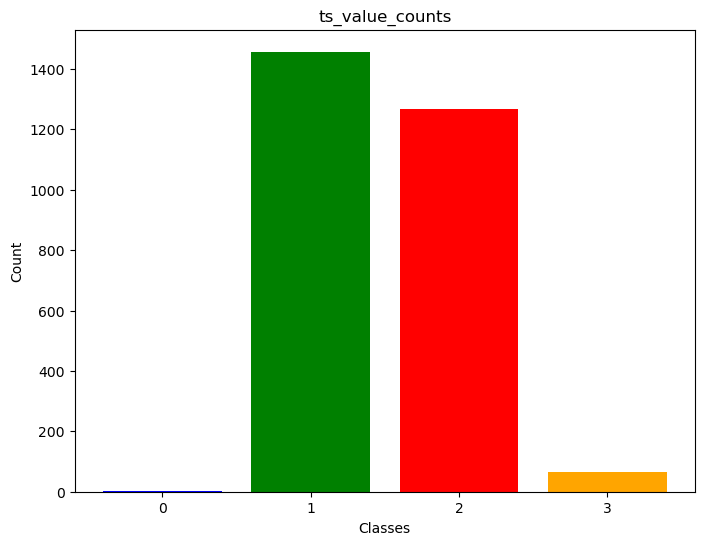

In [18]:
ts_value_counts = ts_submission_df['target'].value_counts().sort_index()

print(ts_value_counts)

plt.figure(figsize=(8, 6))
plt.bar(ts_value_counts.index, ts_value_counts.values, color=['blue', 'green', 'red', 'orange'])
plt.xticks([0, 1, 2, 3])
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('ts_value_counts')
plt.show()